# EDA

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from ydata_profiling import ProfileReport
import os

%matplotlib inline

In [2]:
df = pd.read_csv('../data/training_set_VU_DM.csv')
df.head()

,srch_id,date_time,site_id,visitor_location_country_id,visitor_hist_starrating,visitor_hist_adr_usd,prop_country_id,prop_id,prop_starrating,prop_review_score,...,comp6_rate_percent_diff,comp7_rate,comp7_inv,comp7_rate_percent_diff,comp8_rate,comp8_inv,comp8_rate_percent_diff,click_bool,gross_bookings_usd,booking_bool
0,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,893,3,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
1,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,10404,4,4.0,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
2,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,21315,3,4.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0
3,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,27348,2,4.0,...,NaN,NaN,NaN,NaN,-1.0,0.0,5.0,0,NaN,0
4,1,2013-04-04 08:32:15,12,187,NaN,NaN,219,29604,4,3.5,...,NaN,NaN,NaN,NaN,0.0,0.0,NaN,0,NaN,0


## Basic Dataset Exploration

In [3]:

print("\n=== DataFrame Info ===")
print(df.info())

print("\n=== Descriptive Stats ===")
print(df.describe())

print("\n=== Shape ===")
print(f"Rows: {df.shape[0]}, Columns: {df.shape[1]}")

print("\n=== Columns ===")
print(", ".join(df.columns))

print("\n=== Uniques per Column ===")
print(df.nunique())

print("\n=== Duplicate Rows ===")
print(f"{df.duplicated().sum()} duplicates")



=== DataFrame Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4958347 entries, 0 to 4958346
Data columns (total 54 columns):
 #   Column                       Dtype  
---  ------                       -----  
 0   srch_id                      int64  
 1   date_time                    object 
 2   site_id                      int64  
 3   visitor_location_country_id  int64  
 4   visitor_hist_starrating      float64
 5   visitor_hist_adr_usd         float64
 6   prop_country_id              int64  
 7   prop_id                      int64  
 8   prop_starrating              int64  
 9   prop_review_score            float64
 10  prop_brand_bool              int64  
 11  prop_location_score1         float64
 12  prop_location_score2         float64
 13  prop_log_historical_price    float64
 14  position                     int64  
 15  price_usd                    float64
 16  promotion_flag               int64  
 17  srch_destination_id          int64  
 18  srch_length_of_sta

## Dataset Overview & Time-Based Feature Extraction

Before diving into EDA or handling missing values, we first explored the dataset structure and extracted features from the `date_time` column:

- Checked number of unique `srch_id` values and their result distribution
- Converted `date_time` to datetime format
- Extracted new features: `year`, `month`, `day`, `hour`, `day_of_week`, and `is_weekend`
- Created seasonal labels (`winter`, `spring`, `summer`, `fall`) based on month
- These features were later used to visualize **search activity patterns over time**, **hourly traffic**, and **booking rates** per season or weekend

The target variable `booking_bool` is highly imbalanced. Only **2.79%** of the rows represent bookings, while the remaining **97.21%** are non-bookings. This imbalance may impact model performance and needs to be taken into account during training and evaluation.


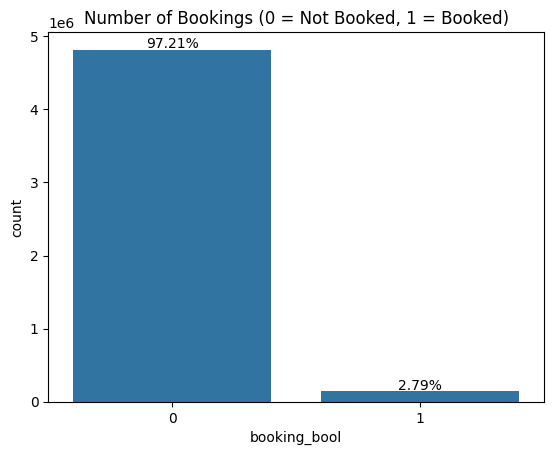

In [4]:
ax = sns.countplot(x='booking_bool', data=df)
plt.title("Number of Bookings (0 = Not Booked, 1 = Booked)")

total = len(df)

for p in ax.patches:
    height = p.get_height()
    percentage = f'{100 * height / total:.2f}%'
    ax.text(p.get_x() + p.get_width()/2., height + total*0.005, percentage, ha="center")

plt.show()


In [5]:
df.dtypes.value_counts()

float64    34
int64      19
object      1
Name: count, dtype: int64

In [6]:
df['srch_id'].nunique()


199795

In [7]:
df['srch_id'].value_counts().describe()

count    199795.000000
mean         24.817173
std           9.113335
min           5.000000
25%          18.000000
50%          29.000000
75%          32.000000
max          38.000000
Name: count, dtype: float64

In [8]:
df['date_time'] = pd.to_datetime(df['date_time'])

In [9]:
print(df['date_time'].min())
print(df['date_time'].max())

2012-11-01 00:08:29
2013-06-30 23:58:24


In [10]:
df['year'] = df['date_time'].dt.year
df['month'] = df['date_time'].dt.month
df['day'] = df['date_time'].dt.day
df['day_of_week'] = df['date_time'].dt.dayofweek  # 0 == Monday, 6 == Sunday
df['hour'] = df['date_time'].dt.hour
hour_counts = df['hour'].value_counts().sort_index()
df['is_weekend'] = df['day_of_week'].isin([5, 6])


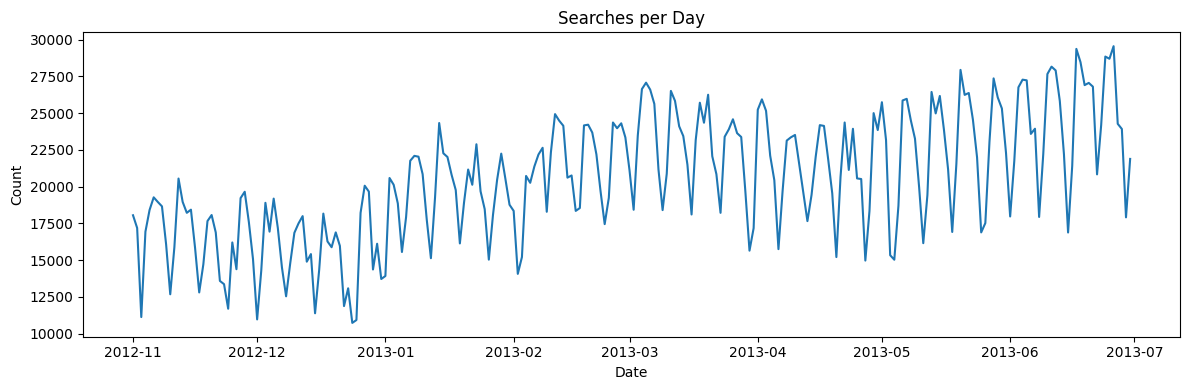

In [11]:
df['date'] = df['date_time'].dt.date
searches_per_day = df.groupby('date').size()

plt.figure(figsize=(12,4))
searches_per_day.plot()
plt.title("Searches per Day")
plt.xlabel("Date")
plt.ylabel("Count")
plt.tight_layout()
plt.show()


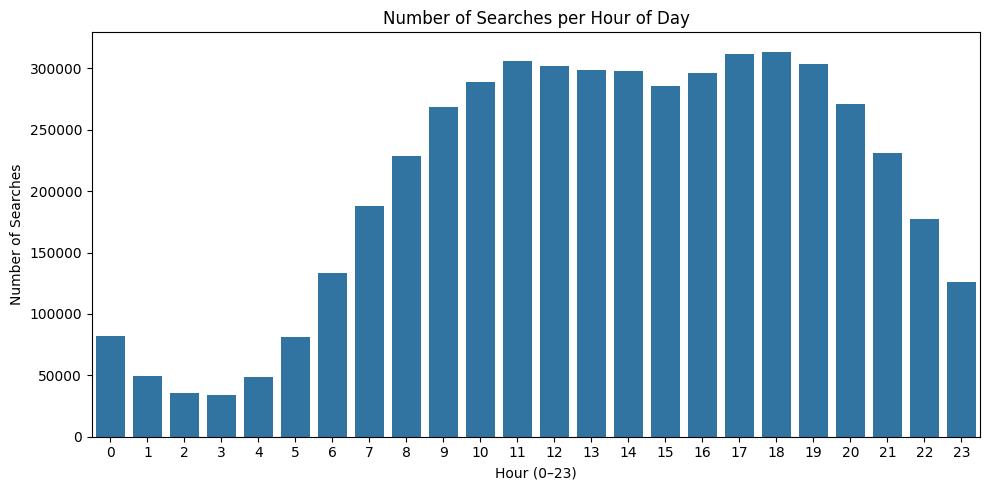

In [12]:
plt.figure(figsize=(10, 5))
sns.barplot(x=hour_counts.index, y=hour_counts.values)
plt.title("Number of Searches per Hour of Day")
plt.xlabel("Hour (0–23)")
plt.ylabel("Number of Searches")
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()


In [13]:
searches_by_hour = df.groupby(['hour', 'is_weekend']).size().reset_index(name='count')

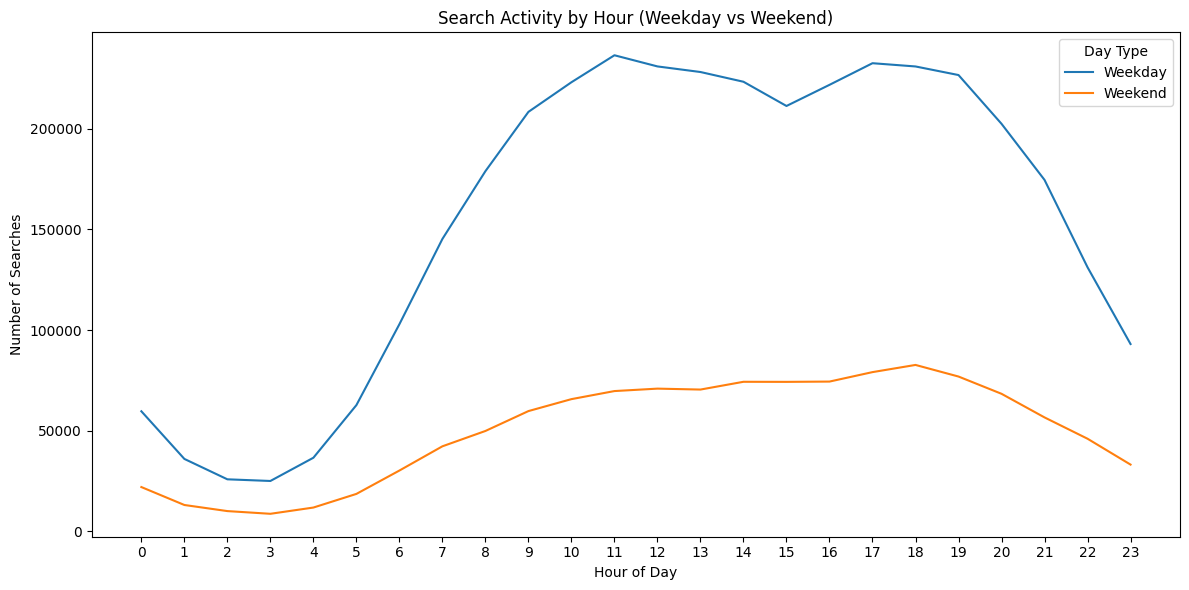

In [14]:
# Convert boolean to readable labels
df['day_type'] = df['is_weekend'].map({False: 'Weekday', True: 'Weekend'})

# Re-group based on new label column
searches_by_hour = df.groupby(['hour', 'day_type']).size().reset_index(name='count')

# Plot with clean legend
plt.figure(figsize=(12, 6))
sns.lineplot(data=searches_by_hour, x='hour', y='count', hue='day_type')
plt.title('Search Activity by Hour (Weekday vs Weekend)')
plt.xlabel('Hour of Day')
plt.ylabel('Number of Searches')
plt.xticks(range(0, 24))
plt.legend(title='Day Type')
plt.tight_layout()
plt.show()

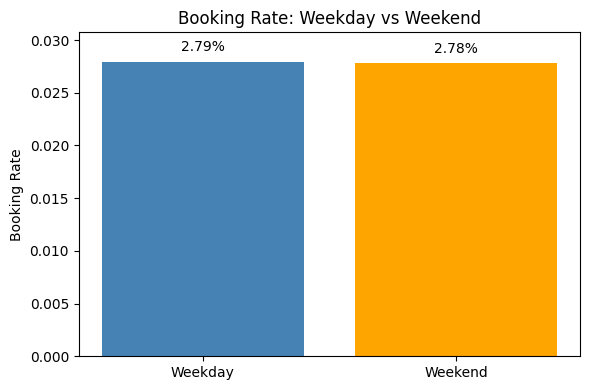

In [ ]:
# Calculate booking rate per day type
booking_by_daytype = df.groupby('day_type')['booking_bool'].agg(['sum', 'count'])
booking_by_daytype['booking_rate'] = booking_by_daytype['sum'] / booking_by_daytype['count']

plt.figure(figsize=(6, 4))
plt.bar(booking_by_daytype.index, booking_by_daytype['booking_rate'], color=['steelblue', 'orange'])
plt.title('Booking Rate: Weekday vs Weekend')
plt.ylabel('Booking Rate')
plt.ylim(0, booking_by_daytype['booking_rate'].max() * 1.1)

for i, rate in enumerate(booking_by_daytype['booking_rate']):
    plt.text(i, rate + 0.001, f'{rate:.2%}', ha='center')

plt.tight_layout()
plt.show()


In [16]:
def get_season(month):
    if month in [12, 1, 2]:
        return 'winter'
    elif month in [3, 4, 5]:
        return 'spring'
    elif month in [6, 7, 8]:
        return 'summer'
    else:
        return 'fall'

df['month'] = df['date_time'].dt.month
df['season'] = df['month'].apply(get_season)


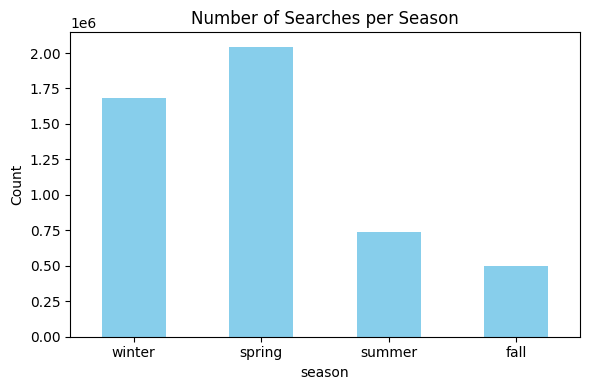

In [17]:
season_counts = df['season'].value_counts().reindex(['winter', 'spring', 'summer', 'fall'])

plt.figure(figsize=(6, 4))
season_counts.plot(kind='bar', color='skyblue')
plt.title('Number of Searches per Season')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()


In [18]:
season_booking = df.groupby('season')['booking_bool'].agg(['sum', 'count'])
season_booking['booking_rate'] = season_booking['sum'] / season_booking['count']


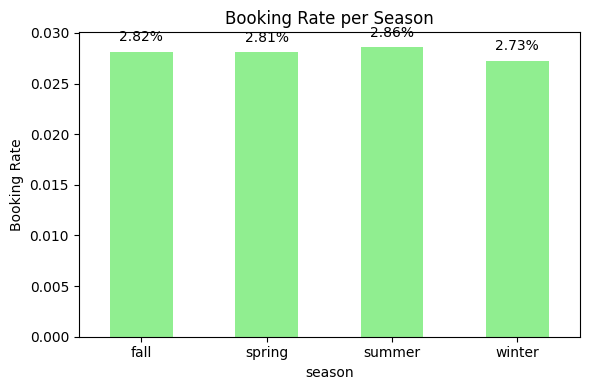

In [19]:
plt.figure(figsize=(6, 4))
season_booking['booking_rate'].plot(kind='bar', color='lightgreen')
plt.title('Booking Rate per Season')
plt.ylabel('Booking Rate')
plt.xticks(rotation=0)

for i, rate in enumerate(season_booking['booking_rate']):
    plt.text(i, rate + 0.001, f'{rate:.2%}', ha='center')

plt.tight_layout()
plt.show()


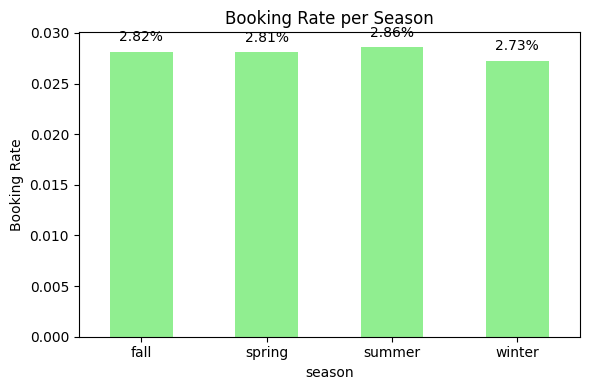

In [ ]:
plt.figure(figsize=(6, 4))
season_booking['booking_rate'].plot(kind='bar', color='lightgreen')
plt.title('Booking Rate per Season')
plt.ylabel('Booking Rate')
plt.xticks(rotation=0)

for i, rate in enumerate(season_booking['booking_rate']):
    plt.text(i, rate + 0.001, f'{rate:.2%}', ha='center')

plt.tight_layout()
plt.show()


Based on the ydata profile report the following can be concluded (html file can be found in the folder):
(I will add the text later...)

In [ ]:
profile = ProfileReport(df, title="Expedia Dataset Profile")
profile.to_file("expedia_report.html")

## Missing values and Imputation

In [21]:
missing_summary = pd.DataFrame({
    "Missing Values": df.isnull().sum(),
    "Missing (%)": df.isnull().mean() * 100
}).sort_values("Missing (%)", ascending=False)

print(missing_summary[missing_summary["Missing Values"] > 0])


                           Missing Values  Missing (%)
comp1_rate_percent_diff           4863908    98.095353
comp6_rate_percent_diff           4862173    98.060362
comp1_rate                        4838417    97.581250
comp1_inv                         4828788    97.387053
comp4_rate_percent_diff           4827261    97.356256
gross_bookings_usd                4819957    97.208949
comp7_rate_percent_diff           4819832    97.206428
comp6_rate                        4718190    95.156511
visitor_hist_starrating           4706481    94.920364
visitor_hist_adr_usd              4705359    94.897735
comp6_inv                         4697371    94.736633
comp4_rate                        4650969    93.800797
comp7_rate                        4642999    93.640058
srch_query_affinity_score         4640941    93.598552
comp4_inv                         4614684    93.069001
comp7_inv                         4601925    92.811677
comp3_rate_percent_diff           4485550    90.464625
comp2_rate

/var/folders/5l/chc1zqqd12d1xl92ym845ntw0000gp/T/ipykernel_92354/293103075.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


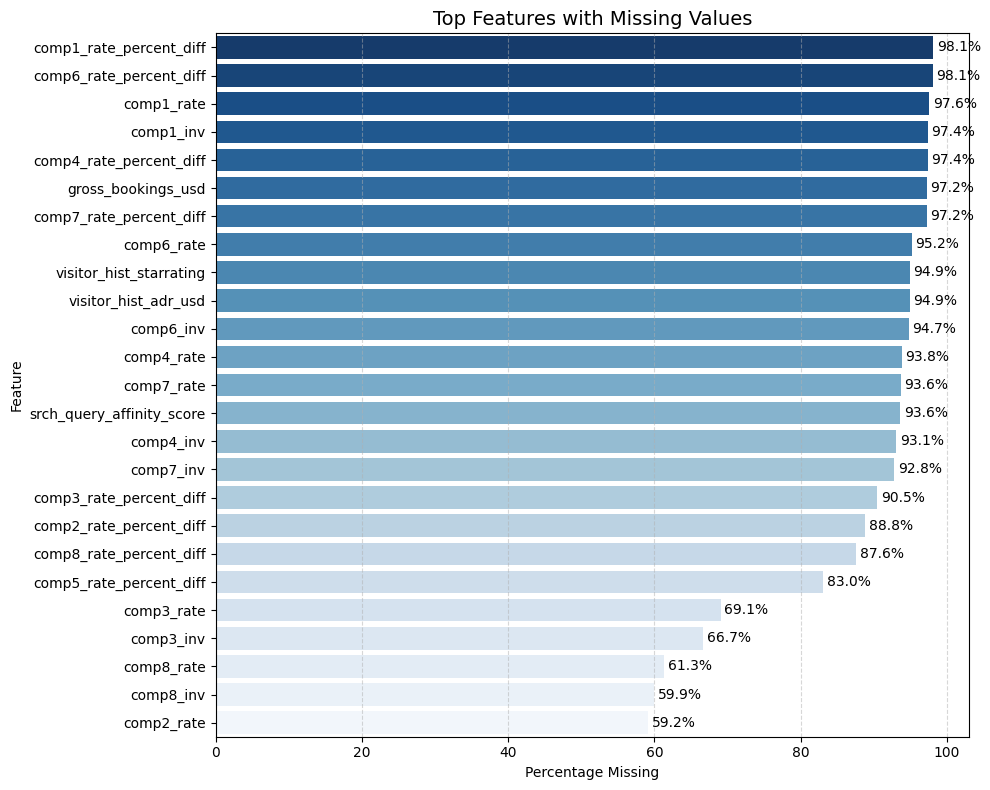

In [22]:
missing_summary = pd.DataFrame({
    "Missing Values": df.isnull().sum(),
    "Missing (%)": df.isnull().mean() * 100
}).sort_values("Missing (%)", ascending=False)

missing_summary = missing_summary[missing_summary["Missing Values"] > 0].head(25)

plt.figure(figsize=(10, 8), facecolor='white')
ax = sns.barplot(
    x="Missing (%)",
    y=missing_summary.index,
    data=missing_summary,
    palette="Blues_r"
)
plt.title("Top Features with Missing Values", fontsize=14)
plt.xlabel("Percentage Missing")
plt.ylabel("Feature")
plt.grid(True, axis='x', linestyle='--', alpha=0.5)

for i, p in enumerate(ax.patches):
    width = p.get_width()
    plt.text(width + 0.5, p.get_y() + p.get_height()/2,
             f'{width:.1f}%', va='center')

plt.tight_layout()
plt.show()

Columns with more than **80% missing values** were dropped. Due to their extreme sparsity, these features were considered too incomplete to impute reliably or contribute meaningfully to the model. Retaining them could introduce noise or bias during training.

In [23]:
 to_drop = [
    'comp1_rate_percent_diff',
    'comp6_rate_percent_diff',
    'comp1_rate',
    'comp1_inv',
    'comp4_rate_percent_diff',
    'gross_bookings_usd',
    'comp7_rate_percent_diff',
    'comp6_rate',
    'visitor_hist_starrating',
    'visitor_hist_adr_usd',
    'comp6_inv',
    'comp4_rate',
    'comp7_rate',
    'srch_query_affinity_score',
    'comp4_inv',
    'comp7_inv',
    'comp3_rate_percent_diff',
    'comp2_rate_percent_diff', 
    'comp8_rate_percent_diff', 
    'comp5_rate_percent_diff'
]

df.drop(columns=to_drop, inplace=True)


### prop_review_score

- Missing in only 0.15% of rows
- No other score was found for the same `prop_id`
- According to the data description, `0` means "no reviews", and `NaN` means "not available"
- Imputed with 0


In [24]:
missing_review_rows = df[df['prop_review_score'].isnull()]
missing_review_rows


,srch_id,date_time,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,...,booking_bool,year,month,day,day_of_week,hour,is_weekend,date,day_type,season
516,45,2013-05-18 09:25:08,14,100,219,122341,0,NaN,0,2.20,...,0,2013,5,18,5,9,True,2013-05-18,Weekend,spring
2907,185,2013-06-28 05:37:16,5,219,127,93773,0,NaN,0,2.08,...,0,2013,6,28,4,5,False,2013-06-28,Weekday,summer
3201,220,2013-06-29 22:21:23,5,219,131,2413,3,NaN,0,0.00,...,0,2013,6,29,5,22,True,2013-06-29,Weekend,summer
4408,321,2013-06-26 20:44:34,24,216,92,21371,3,NaN,0,3.14,...,0,2013,6,26,2,20,False,2013-06-26,Weekday,summer
4409,321,2013-06-26 20:44:34,24,216,92,45035,3,NaN,0,3.04,...,0,2013,6,26,2,20,False,2013-06-26,Weekday,summer
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4953994,332497,2013-06-12 07:52:00,5,219,219,66864,2,NaN,1,0.69,...,0,2013,6,12,2,7,False,2013-06-12,Weekday,summer
4956729,332661,2013-06-20 18:32:31,25,215,73,43834,2,NaN,0,4.90,...,0,2013,6,20,3,18,False,2013-06-20,Weekday,summer
4957751,332735,2013-06-04 23:50:43,24,216,92,106188,3,NaN,0,4.51,...,0,2013,6,4,1,23,False,2013-06-04,Weekday,summer
4957752,332735,2013-06-04 23:50:43,24,216,92,112387,4,NaN,0,4.49,...,0,2013,6,4,1,23,False,2013-06-04,Weekday,summer


In [25]:
df.loc[df['prop_id'] == 81991, df.columns[df.columns.str.startswith('prop_')]]


,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,prop_location_score2,prop_log_historical_price
15496,99,81991,2,NaN,0,3.64,NaN,0.0
525820,99,81991,2,NaN,0,3.64,NaN,0.0
2498275,99,81991,2,NaN,0,3.64,NaN,0.0
3795577,99,81991,2,NaN,0,3.64,NaN,0.0
3888560,99,81991,2,NaN,0,3.64,NaN,0.0
4729537,99,81991,2,NaN,0,3.64,NaN,0.0


In [26]:
missing_prop_ids = missing_review_rows['prop_id'].unique().tolist()
len(missing_prop_ids)

1654

In [27]:
# Check how many bookings are made for properties with missing review scores
subset = df[df['prop_id'].isin(missing_prop_ids)]

booked_subset = subset[subset['booking_bool'] == 1]

print(f"Booked properties with missing review score: {len(booked_subset)}")
print(f"Out of total missing-review properties: {len(subset)}")
print(f"Booking rate: {len(booked_subset) / len(subset):.2%}")


Booked properties with missing review score: 116
Out of total missing-review properties: 7364
Booking rate: 1.58%


In [28]:
known_prop_ids = df.loc[~df['prop_review_score'].isnull(), 'prop_id'].unique()

recoverable_prop_ids = list(set(missing_prop_ids) & set(known_prop_ids))

print(f"Number of recoverable prop_ids: {len(recoverable_prop_ids)}")
print(recoverable_prop_ids[:10])  # Show first 10


Number of recoverable prop_ids: 0
[]


In [29]:
df['prop_review_score'].fillna(0, inplace=True)

/var/folders/5l/chc1zqqd12d1xl92ym845ntw0000gp/T/ipykernel_92354/1138368007.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prop_review_score'].fillna(0, inplace=True)


### prop_location_score2

- Approximately **22%** of the values were missing.
- This variable represents a second location quality score for the property.
- We checked whether the score could be recovered from other rows with the same `prop_id`, and successfully filled in a large portion this way.
- After imputation using known values from the same hotel, the missing rate dropped to ~3.6%.
- Remaining missing values (with no known score across the dataset) were imputed with **0** as a fallback.


In [30]:
# Get prop_ids where score2 is missing
missing_score2_ids = df[df['prop_location_score2'].isnull()]['prop_id'].unique()

# Get prop_ids where score2 is known
known_score2_ids = df[~df['prop_location_score2'].isnull()]['prop_id'].unique()

# Find intersection — props that have both missing and known values
recoverable_score2_ids = list(set(missing_score2_ids) & set(known_score2_ids))

print(f"Number of recoverable prop_ids: {len(recoverable_score2_ids)}")
print(recoverable_score2_ids[:10])  



Number of recoverable prop_ids: 76850
[np.int64(131072), np.int64(131074), np.int64(3), np.int64(4), np.int64(131077), np.int64(6), np.int64(7), np.int64(8), np.int64(9), np.int64(131078)]


In [31]:
score2_lookup = df.loc[~df['prop_location_score2'].isnull(), ['prop_id', 'prop_location_score2']] \
                  .drop_duplicates(subset='prop_id') \
                  .set_index('prop_id')['prop_location_score2']


In [32]:
df['prop_location_score2'] = df.apply(
    lambda row: score2_lookup[row['prop_id']] 
    if pd.isnull(row['prop_location_score2']) and row['prop_id'] in score2_lookup 
    else row['prop_location_score2'],
    axis=1
)


In [33]:
df['prop_location_score2'].fillna(0, inplace=True)


/var/folders/5l/chc1zqqd12d1xl92ym845ntw0000gp/T/ipykernel_92354/1888531129.py:1: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['prop_location_score2'].fillna(0, inplace=True)


### orig_destination_distance

- ~32% of values were missing.
- According to the data description, a missing value indicates that the distance between the customer and the hotel **could not be calculated**.
- We considered attempting to compute the distance based on other fields (e.g., `visitor_location_country_id` and `srch_destination_id`), but due to the lack of coordinate data, this was not feasible.
- Additionally, we found that **44,689** bookings occurred even when this field was missing — indicating that incomplete values is **not random** and still valuable.
- We imputed missing values with **-1** to clearly signal 'unknown', and added a binary flag to preserve the original incomplete values (we will have to take this column in account when normalizing, since it is not a valid low distance!).


In [34]:
df['orig_destination_distance']

0             NaN
1             NaN
2             NaN
3             NaN
4             NaN
            ...  
4958342    550.92
4958343    553.14
4958344    544.43
4958345    550.38
4958346    583.25
Name: orig_destination_distance, Length: 4958347, dtype: float64

In [35]:
# Get rows where orig_destination_distance is missing
missing_distance = df[df['orig_destination_distance'].isnull()]

# Check how many of them resulted in a booking
num_booked = missing_distance['booking_bool'].sum()
total_missing = len(missing_distance)

# Compute booking rate
rate = num_booked / total_missing

print(f"Bookings with missing distance: {num_booked} out of {total_missing} ({rate:.2%})")


Bookings with missing distance: 44689 out of 1607782 (2.78%)


In [36]:
# Step 1: Flag
df['orig_distance_missing'] = df['orig_destination_distance'].isnull().astype(int)

# Step 2: Impute with -1
df['orig_destination_distance'].fillna(-1, inplace=True)


## okay these are the remaining missing values that needs to somehow vanish lol

In [37]:
missing_summary = pd.DataFrame({
    "Missing Values": df.isnull().sum(),
    "Missing (%)": df.isnull().mean() * 100
}).sort_values("Missing (%)", ascending=False)

print(missing_summary[missing_summary["Missing Values"] > 0])

            Missing Values  Missing (%)
comp3_rate         3424059    69.056462
comp3_inv          3307357    66.702814
comp8_rate         3041693    61.344900
comp8_inv          2970844    59.916016
comp2_rate         2933675    59.166392
comp2_inv          2828078    57.036710
comp5_rate         2735974    55.179155
comp5_inv          2598327    52.403089


In [38]:
df

,srch_id,date_time,site_id,visitor_location_country_id,prop_country_id,prop_id,prop_starrating,prop_review_score,prop_brand_bool,prop_location_score1,...,year,month,day,day_of_week,hour,is_weekend,date,day_type,season,orig_distance_missing
0,1,2013-04-04 08:32:15,12,187,219,893,3,3.5,1,2.83,...,2013,4,4,3,8,False,2013-04-04,Weekday,spring,1
1,1,2013-04-04 08:32:15,12,187,219,10404,4,4.0,1,2.20,...,2013,4,4,3,8,False,2013-04-04,Weekday,spring,1
2,1,2013-04-04 08:32:15,12,187,219,21315,3,4.5,1,2.20,...,2013,4,4,3,8,False,2013-04-04,Weekday,spring,1
3,1,2013-04-04 08:32:15,12,187,219,27348,2,4.0,1,2.83,...,2013,4,4,3,8,False,2013-04-04,Weekday,spring,1
4,1,2013-04-04 08:32:15,12,187,219,29604,4,3.5,1,2.64,...,2013,4,4,3,8,False,2013-04-04,Weekday,spring,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4958342,332785,2013-06-30 19:55:18,5,219,219,77700,3,4.0,1,1.61,...,2013,6,30,6,19,True,2013-06-30,Weekend,summer,0
4958343,332785,2013-06-30 19:55:18,5,219,219,88083,3,4.0,1,1.95,...,2013,6,30,6,19,True,2013-06-30,Weekend,summer,0
4958344,332785,2013-06-30 19:55:18,5,219,219,94508,3,3.5,1,1.10,...,2013,6,30,6,19,True,2013-06-30,Weekend,summer,0
4958345,332785,2013-06-30 19:55:18,5,219,219,128360,3,5.0,1,1.95,...,2013,6,30,6,19,True,2013-06-30,Weekend,summer,0
